# Visualization of the Brain Structure in Schizophrenia using Dimension Reduction Analysis

By: Shaun Chen

In this project, we show how to use geomstats to perform a shape data analysis using landmarks in the brain. Specifically, we aim to study the difference between two groups of data:
- Schizophrenic Patients
- Healthy Patients

Data provided by Fred Bookstein
https://sbmorphometrics.org/data/book-schizo.dta
 - A little data set of 13 landmarks for 28 parasagittal brain images: 14 healthy and 14 schizophrenics patients

Biomedical Question: Is dimensionality reduction useful on brain landmarks for determining trends in schizophrenic patients?

## Set up

In [11]:
import os
import sys
import warnings

sys.path.append(os.path.dirname(os.getcwd()))
warnings.filterwarnings("ignore")

In [12]:
%matplotlib inline
import matplotlib.colors as colors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import geomstats.backend as gs
import geomstats.datasets.utils as data_utils
from geomstats.geometry.pre_shape import PreShapeSpace, KendallShapeMetric
import pandas
import numpy as np

  The following data set totals 364 coordinate pairs, one per line: thirteen landmark points for each of 28 cases.  The data set is described in Bookstein, "Biometrics, biomathematics, and the morphometric synthesis," Bulletin of Mathematical Biology, to appear, and also in John DeQuardo et al., "Spatial  relationships of neuroanatomic landmarks in schizophrenia,"  Psychiatry Research: Neuroimaging, to appear.  The pertinent GLS superposition and group means will appear shortly in my article in Proceedings of the 27th Conference on the Interface. 

  The coordinate pairs are ordered as landmarks within cases: thus, (-0.3563, 0.234) is the location of the second landmark for case 1, and (0.2795, 0.0079) is the first landmark of the last case.  The last fourteen cases were diagnosed schizophrenic; the first fourteen, ostensibly not. The coordinates were digitized in Bill Green's program Edgewarp from parasagittal MR images all to the same geometry. Images were digitized just as they were produced by the MR scanner, without translation, rotation, or rescaling; hence, although scale is unknown, it is the same for all 28 images.  The cases are all facing left.

  The landmarks were taken in the near midline from MR images of the brain:

- (1) splenium, posteriormost point on corpus callosum
- (2) genu, anteriormost point on corpus callosum
- (3) top of corpus callosum, uppermost point on arch of callosum (all three to an approximate registration on the diameter of the callosum
- (4) top of head, a point relaxed from a standard landmark along the apparent margin of the dura
- (5) tentorium of cerebellum at dura
- (6) top of cerebellum
- (7) tip of fourth ventricle
- (8) bottom of cerebellum
- (9) top of pons, anterior margin
- (10) bottom of pons, anterior margin
- (11) optic chiasm 
- (12) frontal pole, extension of a line from #1 through #2 until it intersects the dura
- (13) superior colliculus

Label 0 refers to a healthy patient, and Label 1 to a patient with schizophrenia.

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/2/24/Human_anatomy_planes%2C_labeled.svg/800px-Human_anatomy_planes%2C_labeled.svg.png width="300">


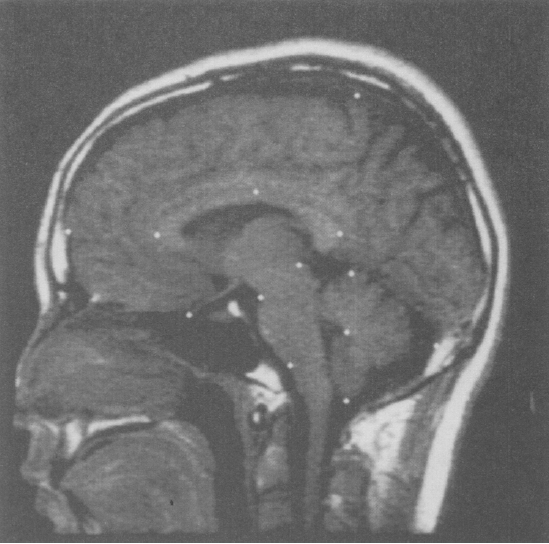

In [13]:
filepath = 'book-schizo.csv'
data = pandas.read_csv(filepath).to_numpy().reshape(28,13,2) #read csv file and convert to numpy array, 364x2 reshaped into 28x13x2
labels = np.append(np.zeros(14, dtype=int), np.ones(14, dtype=int)) #create labels for each class
patient = np.concatenate([([i]*2) for i in range(14)], axis=0) #

print("The loaded data has dimensions:", data.shape)
print("First half patients are healthy, second half have schizophrenia")
print("We set our labels as:", labels)
print("We set our patient ID as:", patient)

The loaded data has dimensions: (28, 13, 2)
First half patients are healthy, second half have schizophrenia
We set our labels as: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
We set our patient ID as: [ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13]


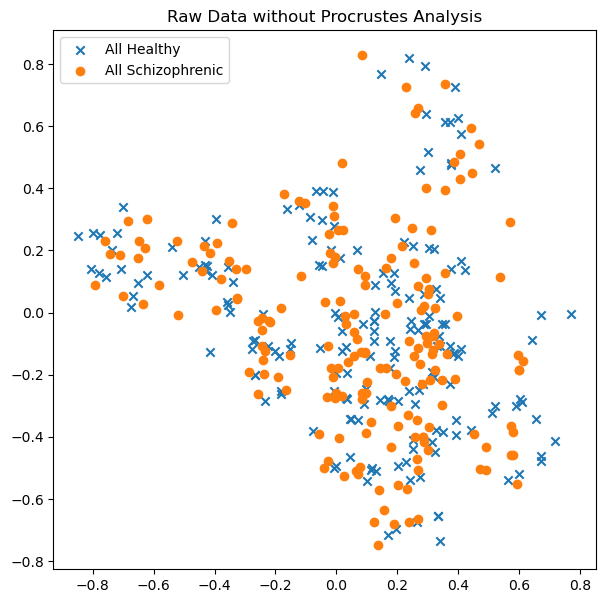

In [14]:
plt.figure(figsize=(7,7))
plt.scatter(data[:14,:,0],data[:14,:,1], marker='x') #all normals
plt.scatter(data[14:,:,0],data[14:,:,1], marker='o') #all shizos
plt.legend(['All Healthy', 'All Schizophrenic'])
plt.title('Raw Data without Procrustes Analysis')
plt.show()

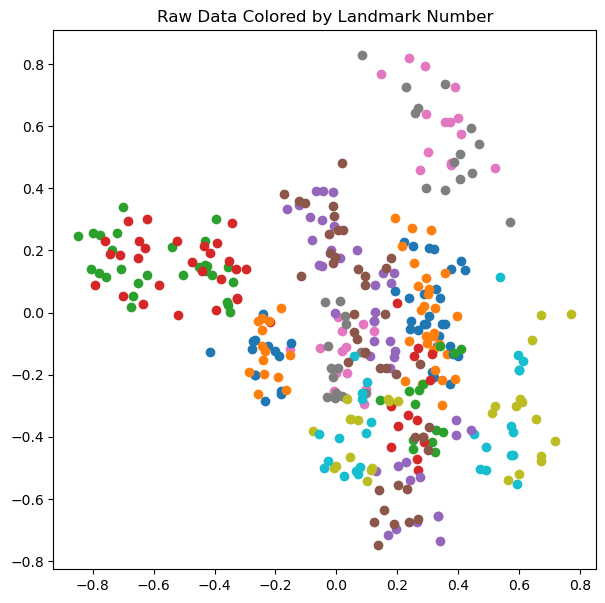

In [15]:
plt.figure(figsize=(7,7))
for i in range(13):
  plt.scatter(data[:14,i,0],data[:14,i,1])
  plt.scatter(data[14:,i,0],data[14:,i,1])
plt.title('Raw Data Colored by Landmark Number')
plt.show()

From the above, we clearly need to do Procrustes Analysis in order to understand the data set better. We use "projection" and "align" found in the geomstats package.

In [16]:
#Perform Procrustes Analysis

m_ambient = 2
k_landmarks = 13

preshape = PreShapeSpace(m_ambient=m_ambient, k_landmarks=k_landmarks)
schizo_preshape = preshape.projection(data)
# print(preshape.belongs(schizo_preshape))
base_point = schizo_preshape[0]
schizo_shape = preshape.align(point=schizo_preshape, base_point=base_point)
print(schizo_shape.shape)

(28, 13, 2)


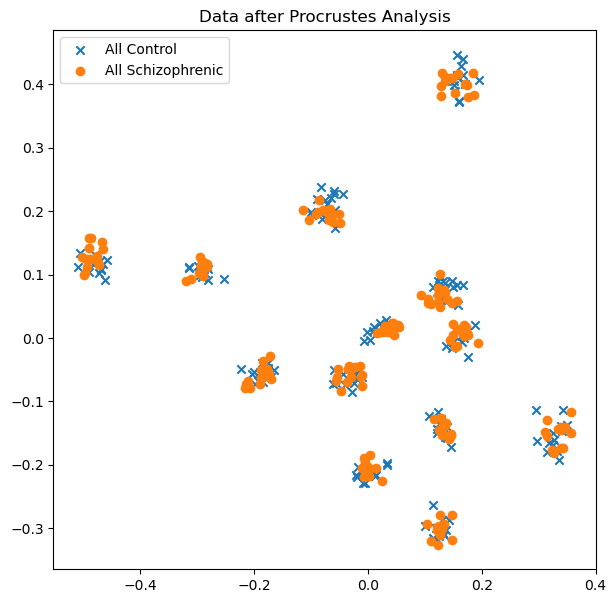

In [17]:
plt.figure(figsize=(7,7))
plt.scatter(schizo_shape[14:,:,0],schizo_shape[14:,:,1], marker='x') #all normals
plt.scatter(schizo_shape[:14,:,0],schizo_shape[:14,:,1], marker='o') #all shizos
plt.legend(['All Control', 'All Schizophrenic'])
plt.title('Data after Procrustes Analysis')
plt.show()

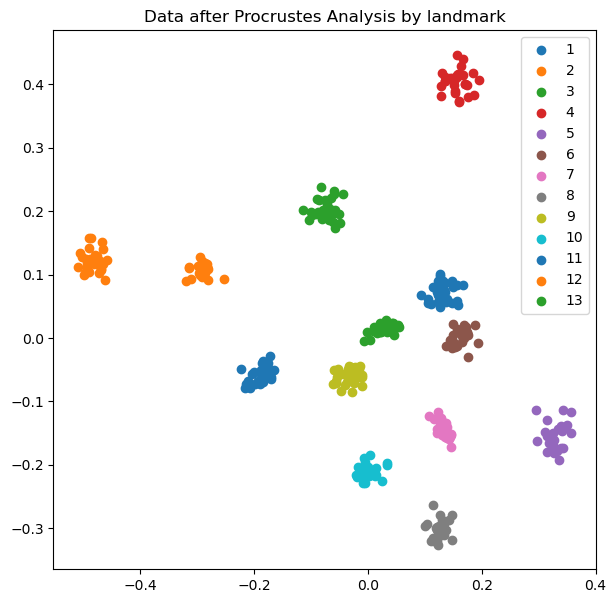

In [18]:
plt.figure(figsize=(7,7))
for i in range(13):
  plt.scatter(schizo_shape[:,i,0],schizo_shape[:,i,1]) #each landmark
plt.legend(['1','2','3','4','5','6','7','8','9','10','11','12','13'])
plt.title('Data after Procrustes Analysis by landmark')
plt.show()

After Procrustes Analysis, clusters for each landmark are shown. Now we can study the plot using dimension reduction.

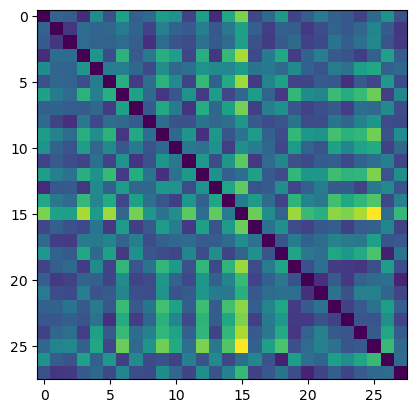

In [19]:
from geomstats.geometry.euclidean import EuclideanMetric

schizo_vec = data.reshape(28, -1)

eucl_metric = EuclideanMetric(schizo_vec.shape[-1])

eucl_dist = eucl_metric.dist_pairwise(schizo_vec)

plt.figure()
plt.imshow(eucl_dist);

This 28x28 Correlation Matrix tells us how similar any two parasagittal images are.

The Kendall metric is a Riemannian metric that takes this alignment into account. It corresponds to the metric of the Kendall shape space, which is the manifold defined as the preshape space quotient by the action of the rotation in m_ambient dimensions, here in 3 dimensions.

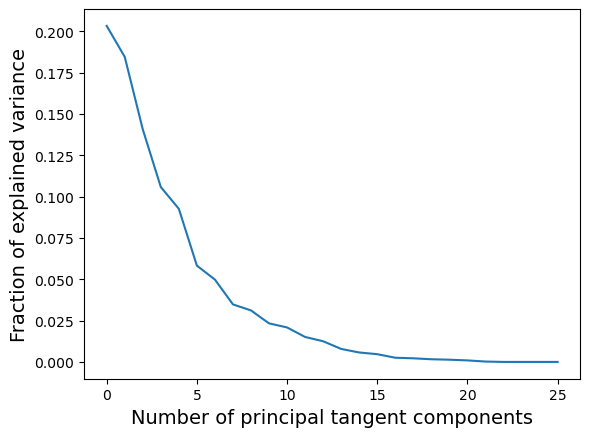

In [20]:
from geomstats.learning.pca import TangentPCA

kendall_metric = KendallShapeMetric(m_ambient=m_ambient, k_landmarks=k_landmarks)
tpca = TangentPCA(kendall_metric)
tpca.fit(schizo_shape)

plt.plot(tpca.explained_variance_ratio_)
plt.xlabel("Number of principal tangent components", size=14)
plt.ylabel("Fraction of explained variance", size=14)
plt.show()

In [21]:
tpca = TangentPCA(kendall_metric, n_components=5)
tpca.fit(schizo_shape)
print('\nVariance of each component:', tpca.explained_variance_ratio_)

print('Total Variance explained by 2 Principal Components:', round(sum(list(tpca.explained_variance_ratio_[:2]))*100, 2), '%')
print('Total Variance explained by 3 Principal Components:', round(sum(list(tpca.explained_variance_ratio_[:3]))*100, 2), '%')
print('Total Variance explained by 4 Principal Components:', round(sum(list(tpca.explained_variance_ratio_[:4]))*100, 2), '%')
print('Total Variance explained by 5 Principal Components:', round(sum(list(tpca.explained_variance_ratio_[:5]))*100, 2), '%')


Variance of each component: [0.20330965 0.18458338 0.14072722 0.10581045 0.09264244]
Total Variance explained by 2 Principal Components: 38.79 %
Total Variance explained by 3 Principal Components: 52.86 %
Total Variance explained by 4 Principal Components: 63.44 %
Total Variance explained by 5 Principal Components: 72.71 %


Unfortunately, lower dimensions in tPCA does not yield a high total variance. We essentially need 5 principal components in order to capture the "essence" of the data.

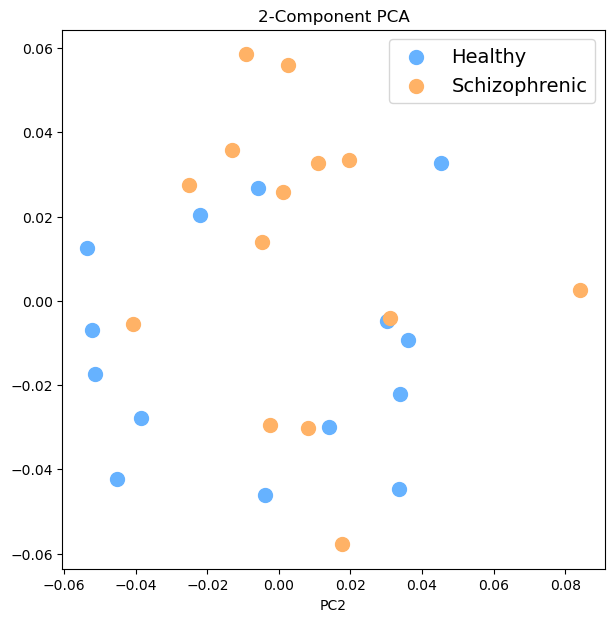

In [22]:
%matplotlib inline
tpca = TangentPCA(kendall_metric, n_components=2)
tpca.fit(schizo_shape)
X = tpca.transform(schizo_shape)

label_to_str = {0: "Healthy", 1: "Schizophrenic"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}

plt.figure(figsize=(7,7))
for label, col in label_to_color.items():
    mask = labels == label
    plt.scatter(X[mask, 0], X[mask, 1], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)
plt.xlabel("PC1")
plt.xlabel("PC2")
plt.title("2-Component PCA");

# patient = np.concatenate([list(range(14)),list(range(14))])
# for label, x, y in zip(patient, X[:, 0], X[:, 1]):
#     plt.annotate(label, xy=(x, y), xytext=(-20, 20), textcoords="offset points", ha="right", va="bottom", bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.5), arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"))


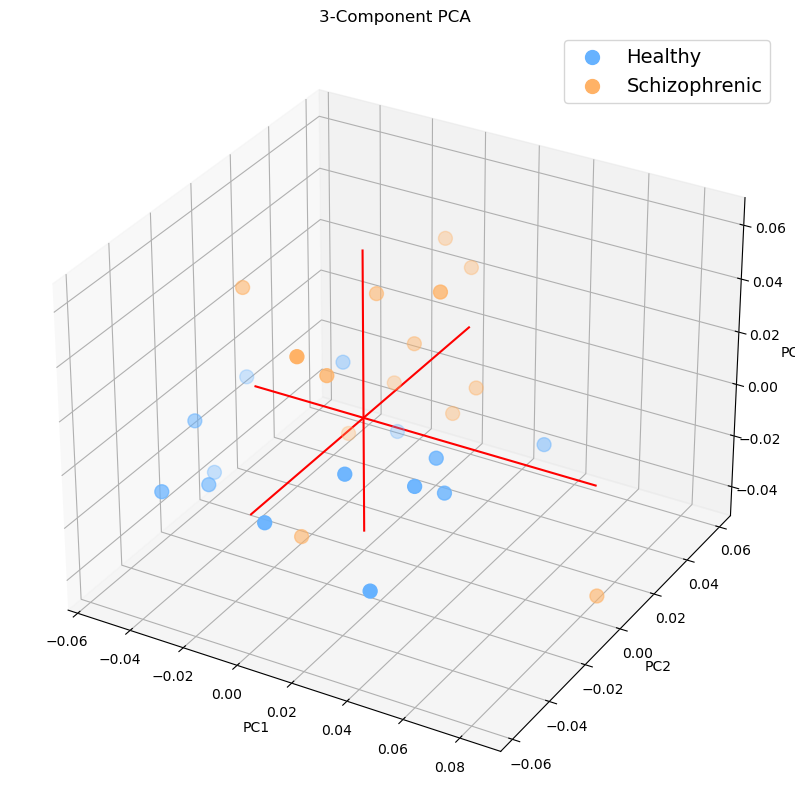

In [23]:
# Run The PCA
tpca = TangentPCA(kendall_metric, n_components=3)
tpca.fit(schizo_shape)
X = tpca.transform(schizo_shape)

label_to_str = {0: "Healthy", 1: "Schizophrenic"}
label_to_color = {
    0: (102 / 255, 178 / 255, 255 / 255, 1.0),
    1: (255 / 255, 178 / 255, 102 / 255, 1.0),
}

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for label, col in label_to_color.items():
    mask = labels == label
    ax.scatter(X[mask, 0], X[mask, 1], X[mask, 2], color=col, s=100, label=label_to_str[label])
plt.legend(fontsize=14)
 
# make simple, bare axis lines through space:
xAxisLine = ((min(X[mask, 0]), max(X[mask, 0])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(X[mask, 1]), max(X[mask, 1])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(X[mask, 2]), max(X[mask, 2])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')
 
# label the axes
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("3-Component PCA")
plt.show()

(28, 28)


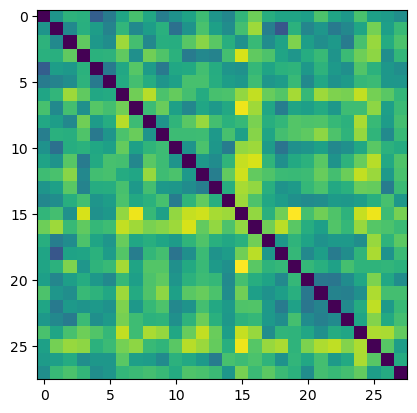

In [24]:
dist_pairwise = kendall_metric.dist_pairwise(schizo_shape)
print(dist_pairwise.shape)

plt.figure()
plt.imshow(dist_pairwise);

We try agglomerative hierarchical clustering to investigate if we can cluster in the Kendall shape space.

In [25]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=2)
clustering.fit(dist_pairwise)
predicted_labels = clustering.labels_

print("True labels:", labels)
print("Predicted labels:", predicted_labels)

accuracy = gs.sum(labels == predicted_labels) / len(labels)
print(f"Accuracy: {accuracy:.2f}")

True labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted labels: [1 0 0 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1]
Accuracy: 0.43


**So to answer the question, it seems that dimensionality reduction is not very useful in terms of determining trends based on the landmarks from slicing MRI images on the brain. Morever, the high variance ratio seems to represent that the schizophrenic and healthy patients are not correlated at all!**

Indeed, Bookstein concluded that "the associated superposition leads to misleading interpretions in most practical applications of shape processes."

So what was the point of his 53 page paper "Biometrics, biomathematics and the morphometric synthesis" in 1996?
Scientist at that time were tempted to find a way to represent these expensive MRI-scanned images as landmark data to make conclusions. Things like cranial growth were more easily analyzable than schizophrenia. However, for this case, he realized he needed more landmarks along the inner border to understand its biometrical properties. He also emphasized that, grabbing isolated landmark data on its own wasn't enough for metrometric analysis; interdisciplintary collaboration between biologists, mathematicians, and staticians must happen in order to understand complex biological shapes and form.